<a href="https://colab.research.google.com/github/ayjabri/ImageClassification/blob/master/Kannanda_MNIST_MixedNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Reading data

Start by importing pandas library and reading test,train and the Dig files

In [0]:
import pandas as pd

## 1.1. Import csv files

In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
dig_MNIST = pd.read_csv('Dig-MNIST.csv')

In [3]:
len(train_df.label),len(test_df.id)

(60000, 5000)

## 1.2. Generate X and Y from training csv file

In [0]:
import torch

For 'x': 
* Drop the label column and extract the 784 reamining columns
* Convert the numpy array to float tensor 
* Reshape the tensor to (60000,28,28) 

In [9]:
x = torch.from_numpy(train_df.drop(labels=['label'],axis=1).values).float()
x = x.view(x.size(0),-1,28,28)

y = torch.from_numpy(train_df.label.values).long()
x.shape,y.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

## 1.3. View data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


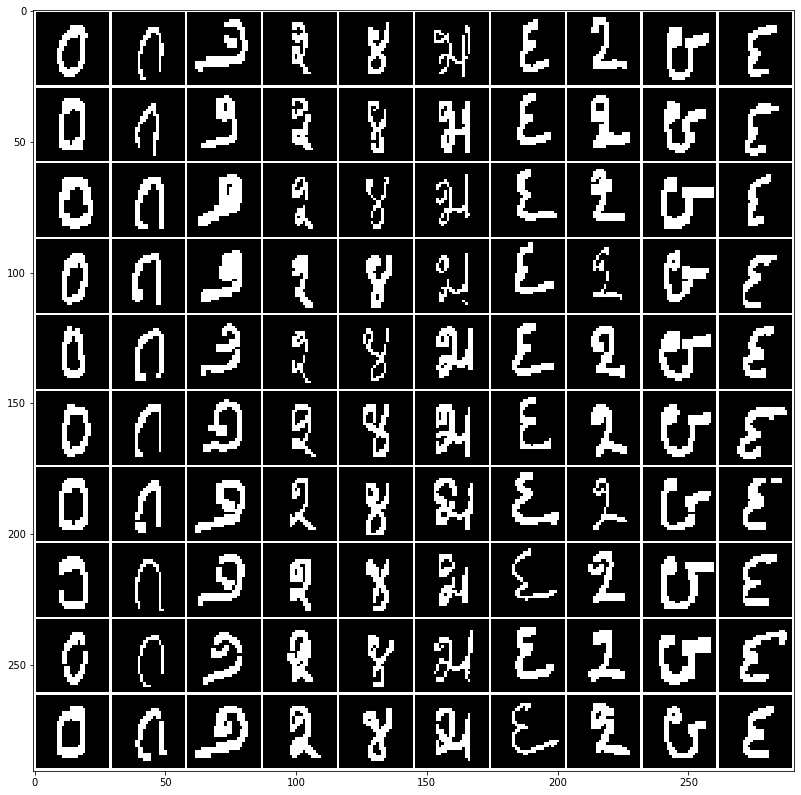

In [10]:
import torchvision as tv
import matplotlib.pyplot as plt
imgs = tv.utils.make_grid(x[:100],nrow=10,padding=1,pad_value=255)

plt.figure(figsize=(14,14))
plt.imshow(imgs.permute(1,2,0),cmap='Greys')

# 2. Dataset and DataLoaders

## 2.1. Write a custom Dataset that allows image transforms

In [0]:
from torch.utils.data import Dataset,DataLoader

In [0]:
class MyDataset(Dataset):
    def __init__(self,x,y,transform=None):
        self.data = x
        self.target = y
        self.transform = transform
    def __len__(self):
        return len(self.target)
    def __getitem__(self,idx):
        label= self.target[idx]
        img = self.data[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img,label

## 2.2. Create the dataset and loader

### 2.2.1. Transforms:

In [0]:
from torchvision import transforms

In [0]:
tfms = transforms.Compose([transforms.Normalize((0.5,),(0.5,))])

### 2.2.2. Dataset and DataLoader
We create a dataset then we split it 20-80 into training and validating datasets.
Then we create two DataLoader: `dl` for training and `dlv` for validation

In [0]:
dsm = MyDataset(x,y,transform=tfms)

ds,dsv = torch.utils.data.random_split(dsm,[48000,12000]) #split the data
dl = DataLoader(ds,batch_size=1000,shuffle=True,pin_memory=True)
dlv = DataLoader(dsv, batch_size=1000, shuffle=False,pin_memory=True)

### 2.2.3. Small Dataset and DataLoader to overfit the Network

In [0]:
sampler = torch.utils.data.RandomSampler(ds,num_samples=500,replacement=True)
dls = DataLoader(ds,batch_size=100,sampler=sampler)

# 3. Mixed Neural Network (1D,2D):

In [0]:
import torch.nn as nn

## 3.1. The Model

In [0]:
class Net(nn.Module):
    def __init__(self,out,kernel):
        super(Net,self).__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(28,out,kernel,padding=3,bias=False),
                                   nn.BatchNorm1d(out),
                                   nn.LeakyReLU(inplace=True),
                                   nn.Conv1d(out,out,kernel-2,padding=3,bias=False),
                                   nn.BatchNorm1d(out),
                                   nn.LeakyReLU(inplace=True),
                                   nn.Conv1d(out,out,kernel-2,padding=3,bias=False),
                                   nn.BatchNorm1d(out),
                                   nn.LeakyReLU(inplace=True)
                                   )
        self.pool1 = nn.AdaptiveAvgPool1d(1)
        self.pool2 = nn.AdaptiveMaxPool1d(1)
        self.drop1 = nn.Dropout(p=0.25)
        
        self.conv2 = nn.Sequential(nn.Conv2d(1,out,kernel,padding=3,bias=False),
                                   nn.BatchNorm2d(out),
                                   nn.LeakyReLU(inplace=True),
                                   nn.Conv2d(out,out,kernel-2,padding=3,bias=False),
                                   nn.BatchNorm2d(out),
                                   nn.LeakyReLU(inplace=True),
                                   nn.Conv2d(out,out,kernel-2,padding=3,bias=False),
                                   nn.BatchNorm2d(out),
                                   nn.ReLU(inplace=True))
        self.pool3 = nn.AdaptiveAvgPool2d(1)
        self.pool4 = nn.AdaptiveMaxPool2d(1)
        self.drop2 = nn.Dropout(p=0.25)

        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(out*4,out*2),
                                nn.BatchNorm1d(int(out*2)),
                                nn.LeakyReLU(inplace=True),
                                nn.Dropout(p=0.5),
                                nn.Linear(out*2,10))
    def forward(self,x):
        x1 = x.squeeze(1)
        x1 = self.conv1(x1)
        p1 = self.pool1(x1)
        p2 = self.pool2(x1)
        x1 = torch.cat((p1,p2),dim=1)
        x1 = self.drop1(x1)
        x2 = self.conv2(x)
        p3 = self.pool3(x2)
        p4 = self.pool4(x2)
        x2 = torch.cat((p3,p4),dim=1)
        x2 = self.drop2(x2)
        x = torch.cat((x1,x2.squeeze(2)),dim=1)
        x = self.fc(x)
        return x

## 3.2. Runner:

The runner is a class that allows me to change output_channels and kernal size to try different combinations

In [0]:
class Runner():
    def __init__(self,out_channels,kernel_size,data,epochs,lr=1e-3):
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.data = data
        self.epochs = epochs
        self.lr = lr
    def run(self):
        net = Net(self.out_channels,self.kernel_size).to(device)
#         summary = SummaryWriter(comment='filters:{} kernel:{} lr:{}'.format(
#             self.out_channels,self.kernel_size,self.lr))
#         summary.add_graph(net,img)
        l,a = learn(net,self.data,self.epochs,self.lr)
        
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('lr={} out_channels={} kernel={}'.format(
            self.lr,self.out_channels,self.kernel_size))
        ax1.set_ylabel('losses', color=color)
        ax1.plot(l, color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
        ax2.plot(a, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()
        return net

## 3.3. Support codes

### 3.3.1 Get the correct number of predections

In [0]:
def get_correct_num(predicts,labels):
    correct = predicts.softmax(dim=1).argmax(dim=1).eq(labels).sum().item()
    accuracy = round(correct/len(labels)*100,3)
    return correct,accuracy

def GPU(img,label):
    if torch.cuda.is_available(): img,label = img.to(device),label.to(device)
    return img,label

### 3.3.2 Predict all samples in DataLoader

In [0]:
@torch.no_grad()
def predict_all(net,dl):
    predicts = torch.tensor([])
    labels = torch.LongTensor([])
    for batch in dl:
        img,label = batch
        net.cpu()
        pred = net(img)
        predicts = torch.cat((predicts,pred),dim=0)
        labels = torch.cat((labels,label),dim=0)
        del img,label # To free memory.very effective when using GPUs
    return predicts,labels

### 3.3.3 Learn function

In [0]:
def learn(net,epochs,dl,dv=None,lr=1e-3):
    '''
    Train the network:
        net: CNN
        epochs: number of epochs
        dl: Training DataLoader
        dv: Validation DataLoader
        lr: Learning rate (defualt=1e-3)
    '''
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=0.9)
    for epoch in range(1,epochs+1):
        losses = 0
        correct = 0
        for batch in dl:
            optimizer.zero_grad()
            img,label = batch
            GPU(img,label)
            output = net(img)
            loss = loss_fn(output,label)
            loss.backward()
            optimizer.step()
            losses += loss.item()
            c,_ = get_correct_num(output,label)
            correct += c
            del img,label
        accuracy = round(correct/len(dl.sampler)*100,3)
        if dv is not None:
            lossv = 0
            correctv = 0
            for valid in dv:
                imv,labelv = valid
                GPU(imv,labelv)
                outputv = net(imv)
                lossv += loss_fn(outputv,labelv)
                cv,_=get_correct_num(outputv,labelv)
                correctv += cv
                del imv,labelv
            accuracyv = round(correctv/len(dv.sampler)*100,3)

            if epoch <=5:    
                print('''{:<3}|Loss: train {:10.12f}, valid {:10.12f} |Accuracy: train {:3}%, valid:{:3}%
                      '''.format(epoch,losses,lossv,accuracy,accuracyv))
            else:
                if epoch%10 ==0:
                    print('''{:<3}|Loss: train {:10.12f}, valid {:10.12f} |Accuracy: train {:3}%, valid:{:3}%
                      '''.format(epoch,losses,lossv,accuracy,accuracyv))
        else:
            if epoch <=5:    
                print('''{:<3}|Loss: train {:10.12f} | Accuracy: train {:3}%
                      '''.format(epoch,losses,accuracy))
            else:
                if epoch%10 ==0:
                    print('''{:<3}|Loss: train {:10.12f} | Accuracy: train {:3}%
                      '''.format(epoch,losses,accuracy))
    return losses,correct


# 4. Run the Network

## 4.1. To GPU

In [23]:
device = 'cuda:0' if torch.cuda.is_available else 'cpu'
device

'cuda:0'

## 4.2. Create and train the network

`Runner_1d(out_channels,kernel_size,data,epochs,lr=1e-3)`

### 4.2.1. Use Runner to create and pre-train the network using the small loader `dls`

In [24]:
r = Runner(64,7,dls,100) 
net = r.run()

RuntimeError: ignored

### 4.2.2. Train the Network with training loader `dl`
If you want to train the network on the combined train & Dig_MNIST datasets, then go to 7.

In [0]:
# loss,accuracy = learn(net,dl,10)

In [0]:
# l,a = learn(net,dl,15,lr=1e-4)

# 5. Save/Load the Network

In [0]:
# TO save the network:
# torch.save(net.state_dict(),'KannadaMNIST_100_7.pt')

In [0]:
# To load the network from saved location, uncomment the below
net = Net1D(100,7)
net.load_state_dict(torch.load('/kaggle/input/parameters/KannadaMNIST_100_7.pt'))

In [0]:
# l,a = learn(net.to(device),dl,5,lr=1e-5)

# 6. Submit the results
## 6.1. Predict Test Set
### 6.1.1. Extract X_test

In [0]:
df_test.head()

In [0]:
x_test = torch.from_numpy(df_test.drop(labels=['id'],axis=1).values).float()
x_test = x_test.view(x_test.size(0),-1,28,28)

### 6.1.1. Create Test Dataset and DataLoader

In [0]:
dlt = DataLoader(x_test,batch_size=100,pin_memory=True)

In [0]:
def pred_submit(net,loader):
    with torch.no_grad():
        predict = torch.tensor([]).to(device)
        for img in loader:
            if torch.cuda.is_available(): img=img.to(device)
            p=net(img)
            predict = torch.cat((predict,p),dim=0)
        submit = predict.argmax(dim=1)
        return predict

In [0]:
submit = pred_submit(m,dlt)

In [0]:
samplesubmission = pd.read_csv('/kaggle/input/Kannada-MNIST/sample_submission.csv')
samplesubmission['label']=pd.DataFrame(submit.argmax(dim=1).cpu().int())
samplesubmission.to_csv("CONV1S.csv", index=False, header=True)
# submit_to_csv('samplesubmission.csv',index=False)

# 7. Dig MNIST

In [0]:
xd = torch.from_numpy(dig_MNIST.drop(['label'],axis=1).values).float()
xd = xd.view(xd.size(0),-1,28,28);xd.shape

yd = torch.from_numpy(dig_MNIST.label.values)

In [0]:
fig, ax = plt.subplots(1)
ax.imshow(xd[7].view(28,28),cmap='Greys')
ax.text(10,30,'Number {}'.format(yd[7]), bbox={'facecolor': 'white', 'pad': 10})
plt.show()

In [0]:
dsd = MyDataset(xd,yd,transform=tfms)

In [0]:
ds_all = torch.utils.data.ConcatDataset((ds,dsd))
dl_all = DataLoader(ds_all,batch_size=200,shuffle=True,pin_memory=True)

In [0]:
loss,accuracy = learn(net.to(device),dl_all,15)

In [0]:
loss,accuracy = learn(net.to(device),dl_all,15,lr=1e-4)

In [0]:
dig_MNIST.isna().sum()

# 8. ResNet

In [0]:
resnet = tv.models.resnet34(pretrained=True)

In [0]:
class AdaptiveConcatPool2d(nn.Module): #This model concatenate Avg and Max pools in one Tensor 
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [0]:
avgpool = nn.Sequential(
                        AdaptiveConcatPool2d(1),
                        nn.Flatten(),
                        nn.BatchNorm1d(1024),
                        nn.Dropout(p=0.25),
                        nn.Linear(1024,512),
                        nn.ReLU(),
                        nn.BatchNorm1d(512),
                        nn.Dropout(p=0.5))
fc = nn.Linear(512,50)

# Using Conv1d only

In [0]:
m = Net1D().to(device)
m.init_weights()

In [0]:
learn(m,50,dls,1e-1);learn(m,10,dl,lr=1e-1);learn(m,10,dl,lr=1e-2);learn(m,10,dl,lr=1e-3)

1: loss:0.06667916337028146 accuracy:99.6%
2: loss:0.060050968546420336 accuracy:99.6%
3: loss:0.04079471528530121 accuracy:99.8%
4: loss:0.08514180267229676 accuracy:99.6%
5: loss:0.10633922112174332 accuracy:99.8%
10: loss:0.029716481221839786 accuracy:100.0%
20: loss:0.08864672121126205 accuracy:99.6%
30: loss:0.06150233279913664 accuracy:99.6%
40: loss:0.06071928492747247 accuracy:99.8%
50: loss:0.04234936251305044 accuracy:99.6%
1: loss:12.19397168874275 accuracy:99.388%
2: loss:8.95889827699284 accuracy:99.559%
3: loss:6.713286598358536 accuracy:99.692%
4: loss:4.511119167389552 accuracy:99.805%
5: loss:5.5902711779745005 accuracy:99.751%
10: loss:2.131090602470067 accuracy:99.907%
1: loss:0.8798348905547755 accuracy:99.969%
2: loss:0.46144167015290805 accuracy:99.99%
3: loss:0.3602612484492056 accuracy:99.994%


In [0]:
torch.save(m.state_dict(),'conv1d_100.pt')